In [352]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import scipy.signal
%config InlineBackend.figure_format='retina'

import sys
sys.path.append("..")

import helper_basic as hp
from helper_basic import *

In [69]:
def finetime_calib(times, low=None, high=None):
    if low is None:
        times = np.array(times)
        mask = (times > 4)& (times < 1000)
        low = np.min(times[mask])
        high=np.max(times[mask])
        
    total_uncalib = high-low
    finetime_calib = (times-low)/total_uncalib*25
    
    return finetime_calib


def load_finetime_comp(filename, ch ="0", ftime_min=None, ftime_max=None, finetime_roll=0):
    
    if type(ch) is str:
        data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=["CHARGE_"+ch, "FINE_"+ch,"RUN_EventTimecode_ns"])
        data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"], low=ftime_min, high=ftime_max)

        if finetime_roll!=0:
            data[f"FINE_calib_{ch}"]= (data[f"FINE_calib_{ch}"]+finetime_roll)%25    
            
    return data


def load_finetime(filename, chs =["0","1"], ftime_min=None, ftime_max=None, finetime_roll=0):
    
    if type(chs) is list:
        keys_to_read = ['RUN_EventTimeCodeLSB', 'RUN_EventTimecode_ns', 'T0_to_Event_Timecode', 'T0_to_Event_Timecode_ns']
        for ch in chs:
            keys_to_read.append("CHARGE_"+ch)
            keys_to_read.append("FINE_"+ch)
            keys_to_read.append("COARSE_"+ch)
            keys_to_read.append("HIT_"+ch)

        data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=keys_to_read)

        for ch in chs:
            data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"], low=ftime_min, high=ftime_max)
            data[f"TIMESTAMP_{ch}"] = (data["COARSE_"+ch]+1)*25 - data[f"FINE_calib_{ch}"]

        return data
    
    elif type(chs) is str:
        return load_finetime_comp(filename, ch =chs, ftime_min=ftime_min, ftime_max=ftime_max, finetime_roll=finetime_roll)
    

In [303]:
DATA_DIR = "E:\\sync\\DT5550W\\"
filename = f"{DATA_DIR}\\163.data"
# data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip")
data = load_finetime(filename, chs =["16","17"])

In [77]:
filename = f"{DATA_DIR}\\150.data"
data_bkg = load_finetime(filename, chs =["16","17"])

In [71]:
# plot(data["COARSE_16"][mask_coinc]-data["COARSE_17"][mask_coinc])

In [99]:
# plot(data["T0_to_Event_Timecode"][:10900])

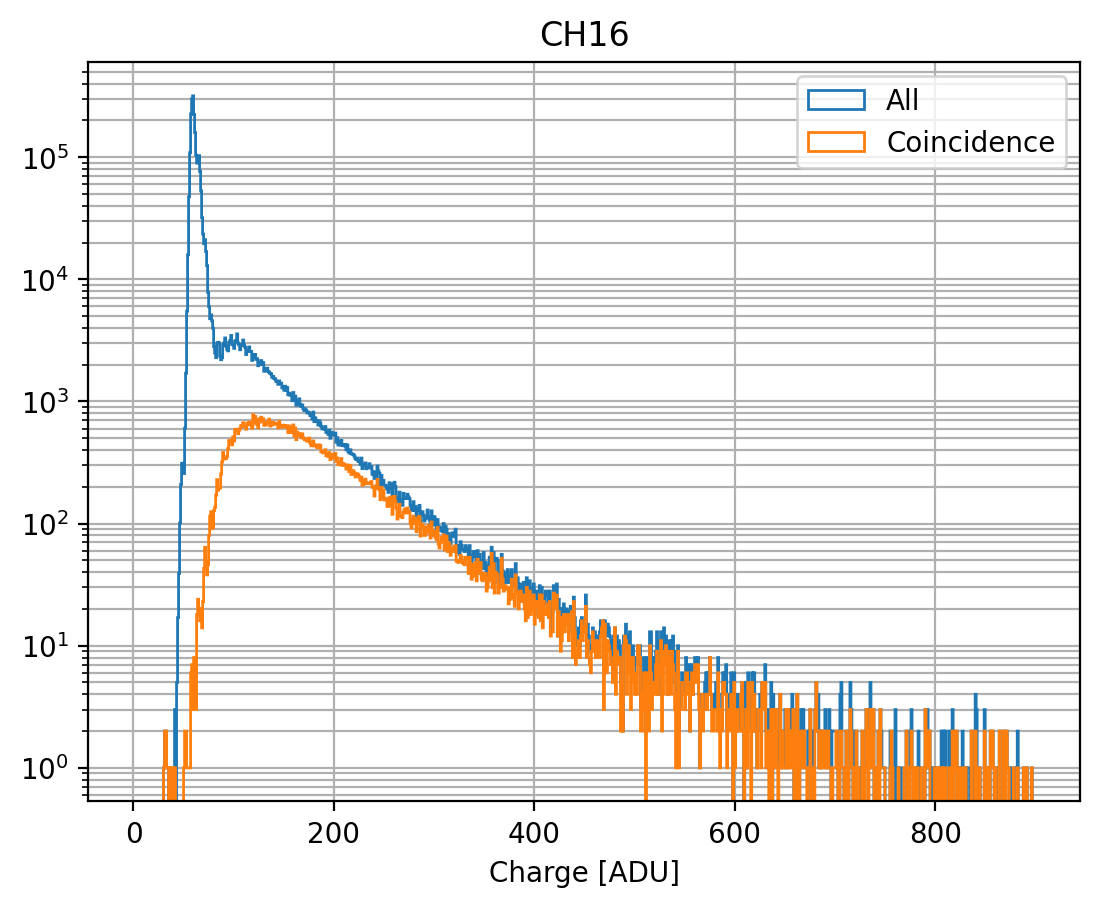

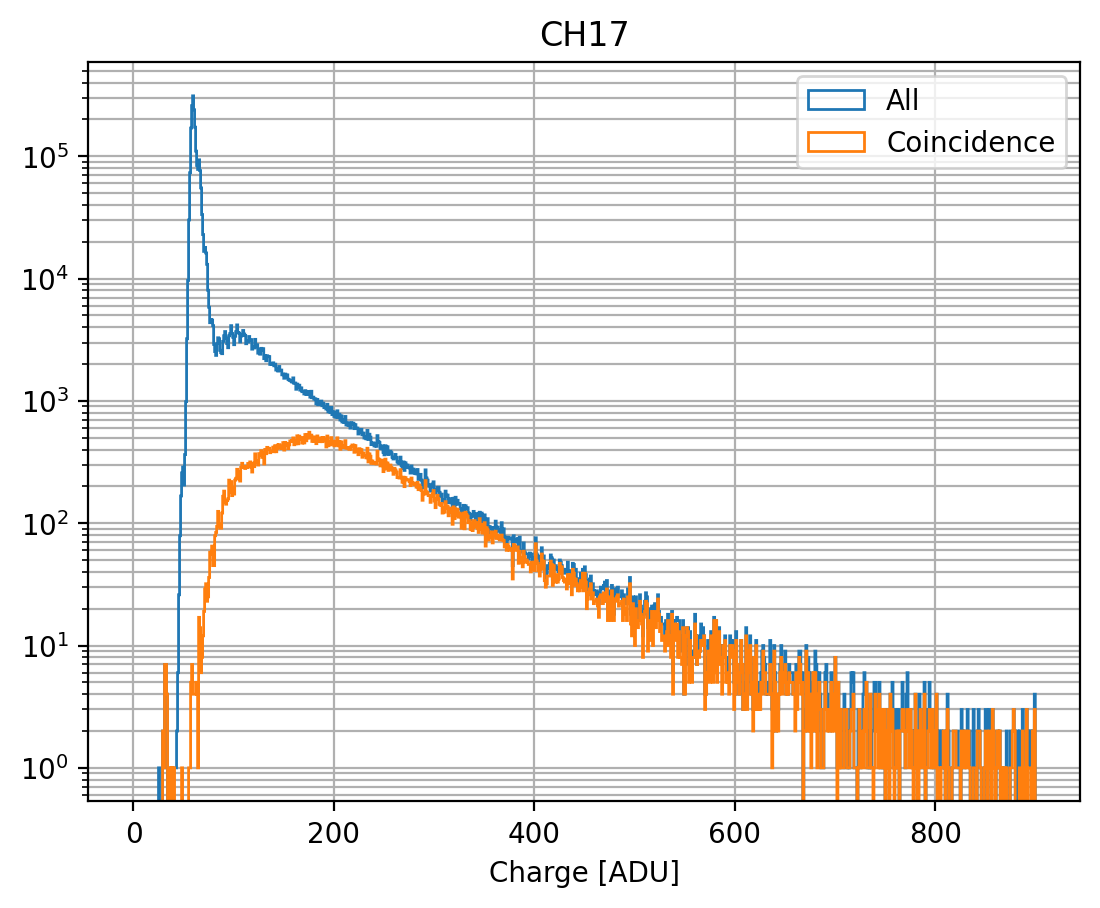

In [304]:
mask_hit16 = (data["HIT_16"]==1)
mask_hit17 = (data["HIT_17"]==1)
mask_coinc = mask_hit16&mask_hit17
mask_charge_16 = data["CHARGE_16"]>75
mask_charge_17 = data["CHARGE_17"]>75
mask_charge_16b = data["CHARGE_16"]>90
charge_min = np.min([data["CHARGE_16"],data["CHARGE_17"]],axis=0)



# hist(data["CHARGE_17"],bins=np.linspace(0,200,201),histtype="step");
hist(data["CHARGE_16"][mask_hit16],bins=np.linspace(0,900,901),histtype="step", label="All");
hist(data["CHARGE_16"][mask_coinc],bins=np.linspace(0,900,901),histtype="step", label="Coincidence");

# hist(data_bkg["CHARGE_16"],bins=np.linspace(0,200,201),histtype="step");
# hist(data_bkg["CHARGE_16"][data_bkg["HIT_16"]==1],bins=np.linspace(0,200,201),histtype="step");

yscale("log")
title("CH16")
xlabel("Charge [ADU]")
legend()
grid(which="both")
show()




# hist(data["CHARGE_17"],bins=np.linspace(0,200,201),histtype="step");
hist(data["CHARGE_17"][mask_hit17],bins=np.linspace(0,900,901),histtype="step", label="All");
hist(data["CHARGE_17"][mask_coinc],bins=np.linspace(0,900,901),histtype="step", label="Coincidence");

yscale("log")
title("CH17")
xlabel("Charge [ADU]")
grid(which="both")
legend()
show()



1.2440836260435757


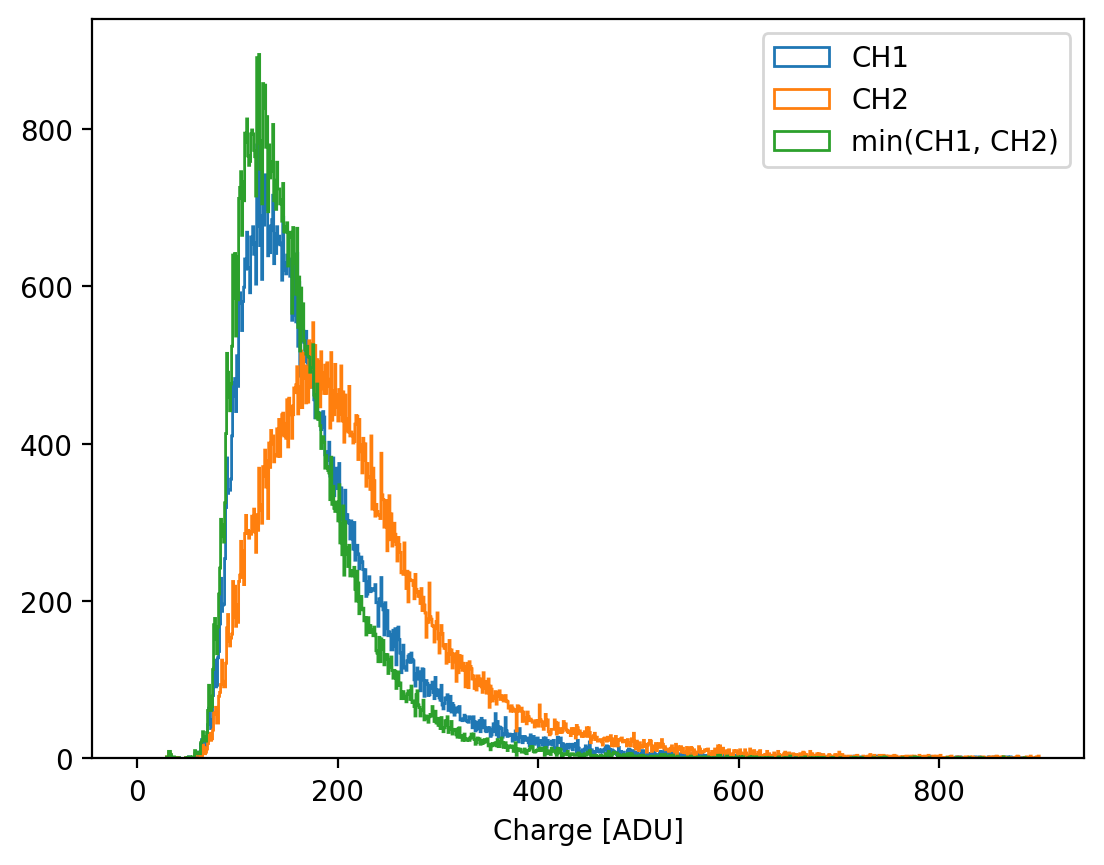

In [349]:
hist((data["CHARGE_16"])[mask_coinc],bins=np.linspace(0,900,901),histtype="step", label="CH1");
hist((data["CHARGE_17"])[mask_coinc],bins=np.linspace(0,900,901),histtype="step", label="CH2");
hist((charge_min)[mask_coinc],bins=np.linspace(0,900,901),histtype="step", label="min(CH1, CH2)");
legend()
xlabel("Charge [ADU]")
print(np.mean((data["CHARGE_17"])[mask_coinc])/np.mean((data["CHARGE_16"])[mask_coinc]))

In [212]:
ch16_charge_avg = np.mean(data["CHARGE_16"][mask_coinc])
ch17_charge_avg = np.mean(data["CHARGE_17"][mask_coinc])
print(ch17_charge_avg/ch16_charge_avg)

1.2301989021173452


In [341]:
50*5* 1/60 * 3600 *10

150000.00000000003

In [340]:
sum(data["CHARGE_17"][mask_hit17]>90), sum(mask_coinc)

(281452, 88414)

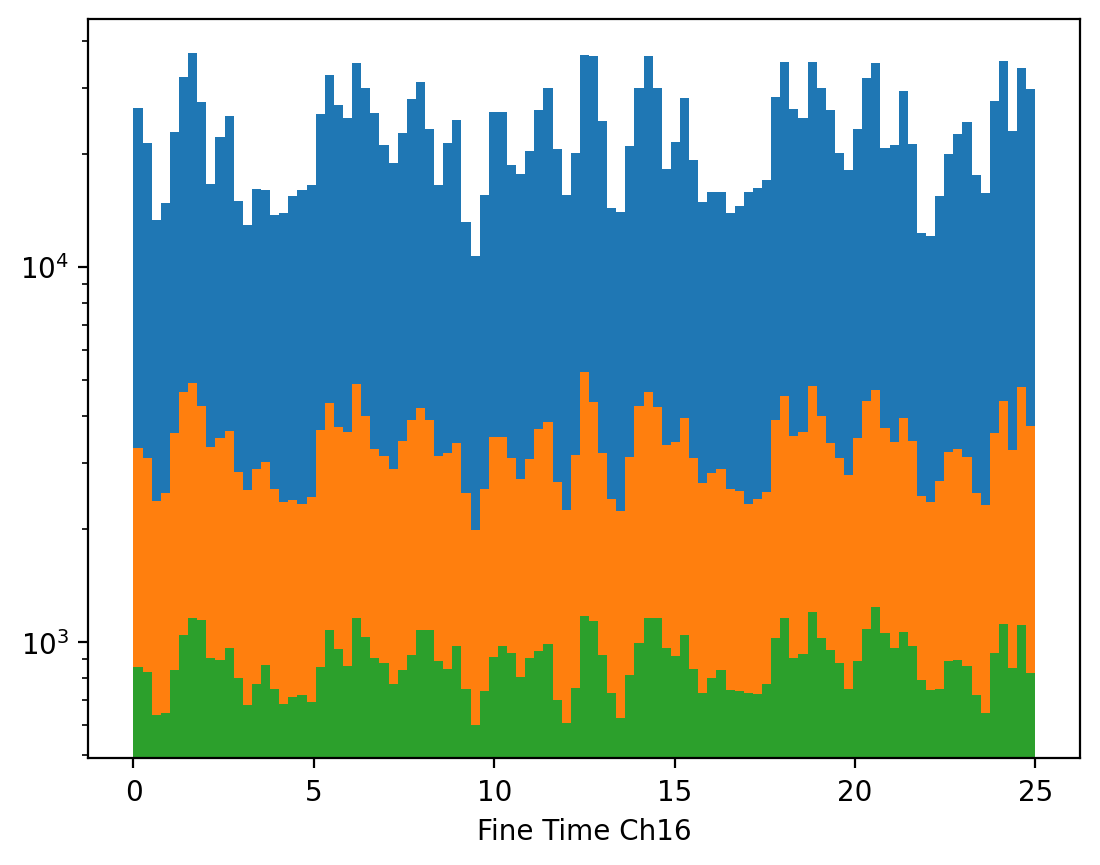

In [308]:
bins=np.linspace(0,25,100)

hist(data.FINE_calib_17, bins=bins)
hist(data.FINE_calib_17[mask_charge_17], bins=bins);
hist(data.FINE_calib_17[mask_charge_17&mask_coinc], bins=bins);
xlabel("Fine Time Ch16")
yscale("log")

In [333]:
import inspect

import scipy
import scipy.optimize
import numpy as np

# from pylab import *


    
def Uniform(x,A):
    if type(x) not in [np.ndarray,list]:
        return A
    else:
        return A*np.ones_like(x)
def Exp(x,A,t):
    return A*np.exp(-x/t)
def Gauss(x, A, mean, sigma):
    return A * np.exp(-(x - mean)**2 / (2 * sigma**2)) 
def Gauss_sideband(x, A, mean, sigma, a1,a2):
    # a1 for left, a2 for right
    return Utils.Gauss(x, A, mean, sigma) + sqrt(2*np.pi)*sigma/2*(a1*scipy.special.erfc((x-mean)/sqrt(2)/sigma) + a2*(2-scipy.special.erfc((x-mean)/sqrt(2)/sigma))) 
def Poisson(k, Lambda,A):
    # Lambda: mean, A: amplitude
    return A*(Lambda**k/scipy.special.factorial(k)) * np.exp(-Lambda)
def Poly(x, *P):
    '''
    Compute polynomial P(x) where P is a vector of coefficients
    Lowest order coefficient at P[0].  Uses Horner's Method.
    '''
    result = 0
    for coeff in P[::-1]:
        result = x * result + coeff
    return result
def Chi2(x, dof, A):
    return scipy.stats.chi2.pdf(x,dof)*A  

def fit_curve(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=None, bounds=(-inf, inf), method=None, jac=None, **kwargs):
   
    if type(f) is str:
        if f in ["Gauss","gauss","gaus"]:
            f=Gauss
            mean = np.sum(xdata*ydata)/np.sum(ydata)
            p0 = [np.max(ydata), mean, np.sqrt(np.sum(ydata*(xdata-mean)**2)/(np.sum(ydata)-1))] if p0 is None else p0
            sigma = np.sqrt(ydata) if sigma is None else sigma; sigma[sigma==0] =1
        elif f in ["Exp", "exp"]:
            f=Exp
            
            
    popt, pcov, info, *_ = scipy.optimize.curve_fit(f, xdata, ydata, p0=p0, sigma=sigma, absolute_sigma=absolute_sigma, check_finite=check_finite, bounds=bounds, method=method, jac=jac, full_output=True, **kwargs)   
    
    return popt, pcov, info, f
    
    
def fit_hist(f, h, plot = True, label=None, fit_range=None, p0=None, sigma=None, absolute_sigma=False, check_finite=None, bounds=(-inf, inf), method=None, jac=None, full_output=False, nan_policy=None, **kwargs):
    def fstr(template, scope):
        return eval(f"f'{template}'", scope)    
    
    xdata = 0.5*(h[1][:-1]+h[1][1:])
    ydata = h[0]
    fit_range = [xdata[0], xdata[-1]] if fit_range is None else fit_range
    mask = (xdata>=fit_range[0]) &(xdata<=fit_range[1])
    xdata = xdata[mask]
    ydata = ydata[mask]
    
    popt, pcov, info, f = fit_curve(f, xdata, ydata, p0=p0, sigma=sigma, absolute_sigma=absolute_sigma, check_finite=check_finite, bounds=bounds, method=method, jac=jac, **kwargs)

    if plot:
        xdata_plot = np.linspace(*fit_range, 200)
        ydata_plot = f(xdata_plot, *popt)
        
        scope = locals()
        func_parameter_names = inspect.getfullargspec(f)[0][1:]
        label = fstr(label,scope) if label is not None else "Fit"
        plt.plot(xdata_plot, ydata_plot, label=label)
    
    return popt, pcov, info, f

Text(0.5, 0, 'dt [ns]')

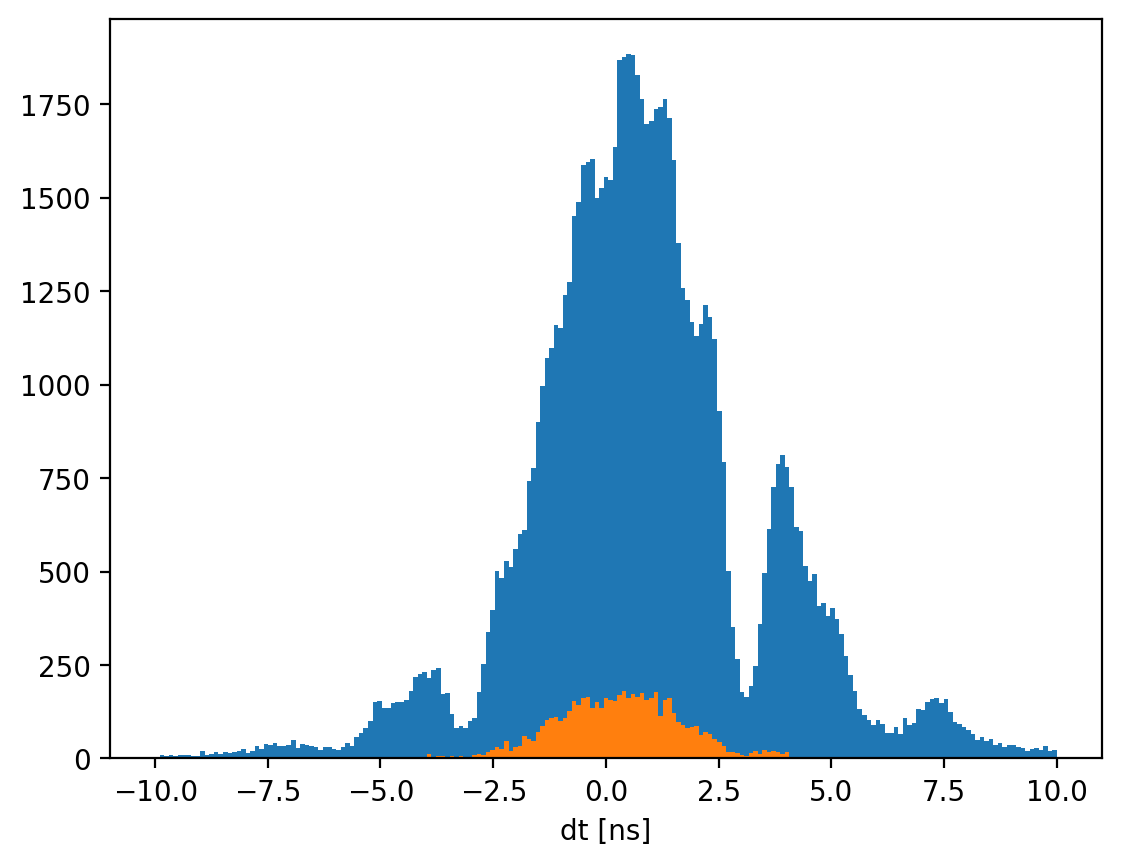

In [325]:
dt = (data.TIMESTAMP_16-data.TIMESTAMP_17)

hist(dt[mask_coinc], bins=np.linspace(-10,10,200));
hist(dt[mask_coinc & (np.abs(charge_min-200)<10)], bins=np.linspace(-10,10,200));
# hist((data.FINE_calib_16-data.FINE_calib_17)[mask_coinc], bins=np.linspace(-20,20,200));
xlabel("dt [ns]")

In [358]:
import importlib
from importlib import reload

In [363]:
reload(hp)

<module 'helper_basic' from 'C:\\Users\\mathusla\\Documents\\MATHUSLA\\JupyterNotebooks\\FineTime\\..\\helper_basic.py'>

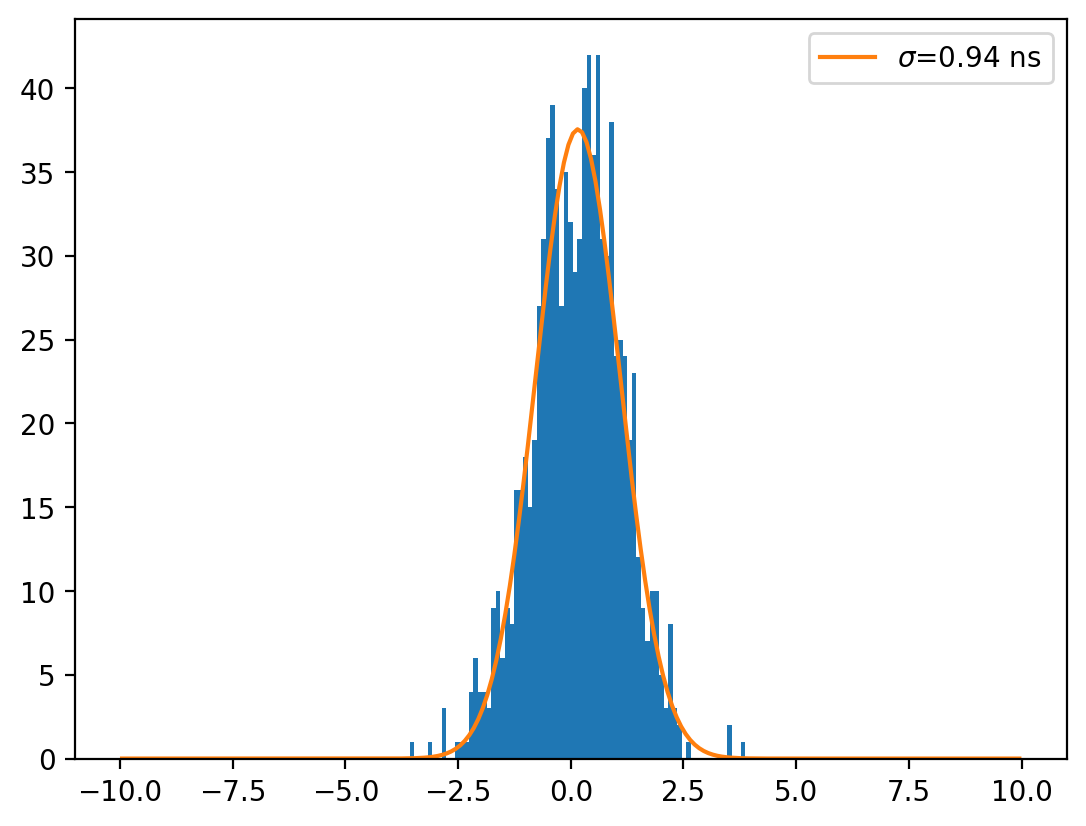

In [364]:
mask = mask_coinc
mask = mask_coinc  & (np.abs(charge_min-300)<10)

h=hist(dt[mask], bins=np.linspace(-10,10,200));
popt, pcov, info, f = hp.fit_hist("gauss", h, label="$\sigma$={popt[2]:.2f} ns");
legend()
# handles, labels = gca().get_legend_handles_labels()

---
# Bars comparison

In [170]:
data1 = load_finetime(f"{DATA_DIR}\\156.data", chs =["16","17"])
data2 = load_finetime(f"{DATA_DIR}\\158.data", chs =["16","17"])
data3 = load_finetime(f"{DATA_DIR}\\159.data", chs =["16","17"])

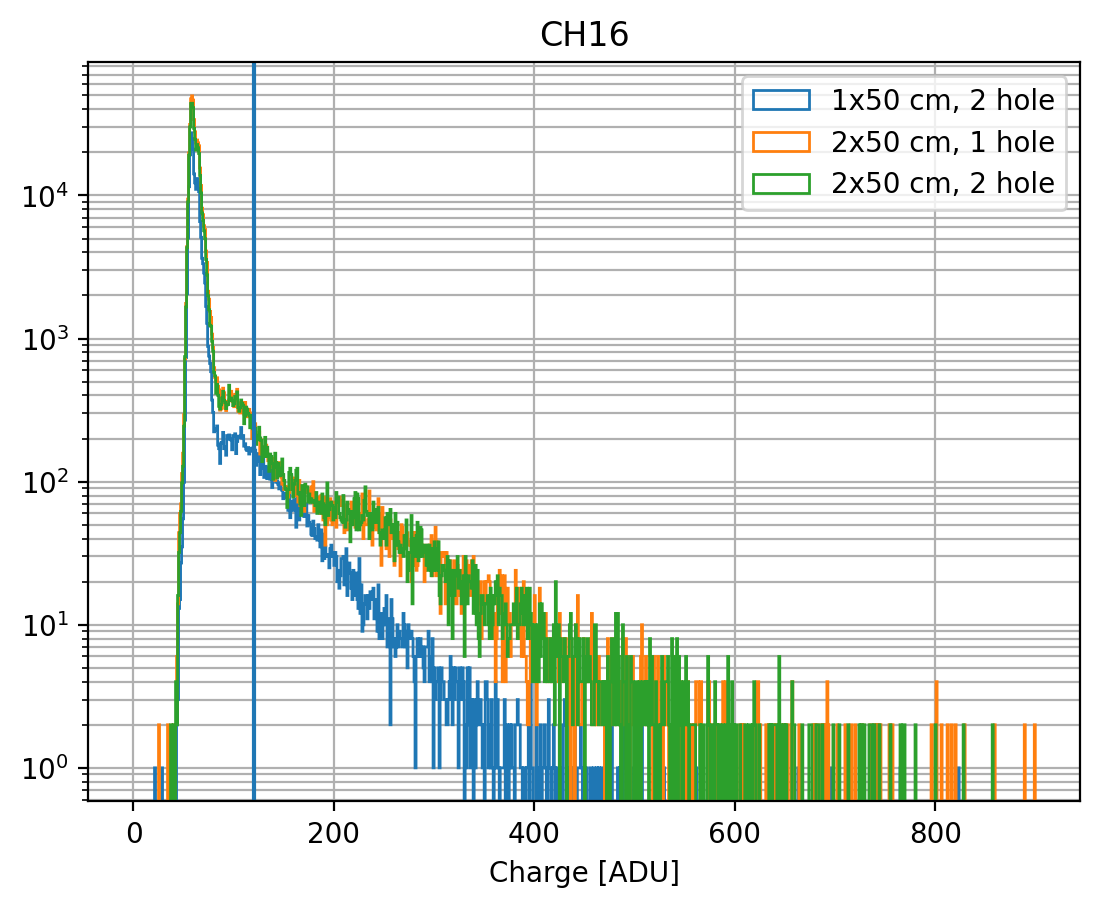

In [242]:
hist(data1["CHARGE_17"][data1["HIT_17"]==1],bins=np.linspace(0,900,901),histtype="step", label="1x50 cm, 2 hole");
hist(data2["CHARGE_17"][data2["HIT_17"]==1],bins=np.linspace(0,900,901),histtype="step", label="2x50 cm, 1 hole", weights = np.ones(sum(data2["HIT_17"]==1))*2);
hist(data3["CHARGE_17"][data3["HIT_17"]==1],bins=np.linspace(0,900,901),histtype="step", label="2x50 cm, 2 hole", weights = np.ones(sum(data3["HIT_17"]==1))*2);
# hist(data["CHARGE_16"][data["HIT_16"]==1],bins=np.linspace(0,900,901),histtype="step", label="2x50 cm, 2 hole");
# hist(data1["CHARGE_17"][data1["HIT_17"]==1].values*2.1,bins=np.linspace(0,900,200),histtype="step", label="1x50 cm, 2 hole");


yscale("log")
title("CH16")
xlabel("Charge [ADU]")
legend()
grid(which="both")
axvline(120)
show()

In [235]:
1/60*50*5 * 3600

15000.000000000002

In [238]:
sum((data3["HIT_17"]==1)&(data3["CHARGE_17"]>120))*2, sum((data1["HIT_17"]==1)&(data1["CHARGE_17"]>120)), 

(15878, 7671)